In [1]:
!nvidia-smi

Mon Jun 17 11:30:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

fatal: destination path 'yolov9' already exists and is not an empty directory.
/content/yolov9


In [4]:
!pip install -q roboflow

## Download model weights

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 804880
drwxr-xr-x 2 root root      4096 Jun 17 11:30 .
drwxr-xr-x 1 root root      4096 Jun 17 11:09 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt.1
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt.1
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt.1
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt.1


## Authenticate and Download the Dataset

In [7]:
%cd {HOME}/yolov9

/content/yolov9


In [8]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mIe6Msc9HLq2EIPGNPoW")
project = rf.workspace("global-solution-sea-garbage").project("garbage-sea-detection")
version = project.version(1)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...


In [9]:
print(dataset.location)

/content/yolov9/Garbage---Sea---Detection-1


## Train Custom Model

In [50]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-06-17 12:23:23.801624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 12:23:23.801676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 12:23:23.902073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 12:23:24.102554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 12:23:25.750067: W

## Examine Training Results

In [51]:
!ls {HOME}/yolov9/runs/train/exp/


confusion_matrix.png				     PR_curve.png	    val_batch0_pred.jpg
events.out.tfevents.1718627006.00347e8e3315.20295.0  R_curve.png	    val_batch1_labels.jpg
F1_curve.png					     results.csv	    val_batch1_pred.jpg
hyp.yaml					     results.png	    val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch0.jpg	    val_batch2_pred.jpg
labels.jpg					     train_batch1.jpg	    weights
opt.yaml					     train_batch2.jpg
P_curve.png					     val_batch0_labels.jpg


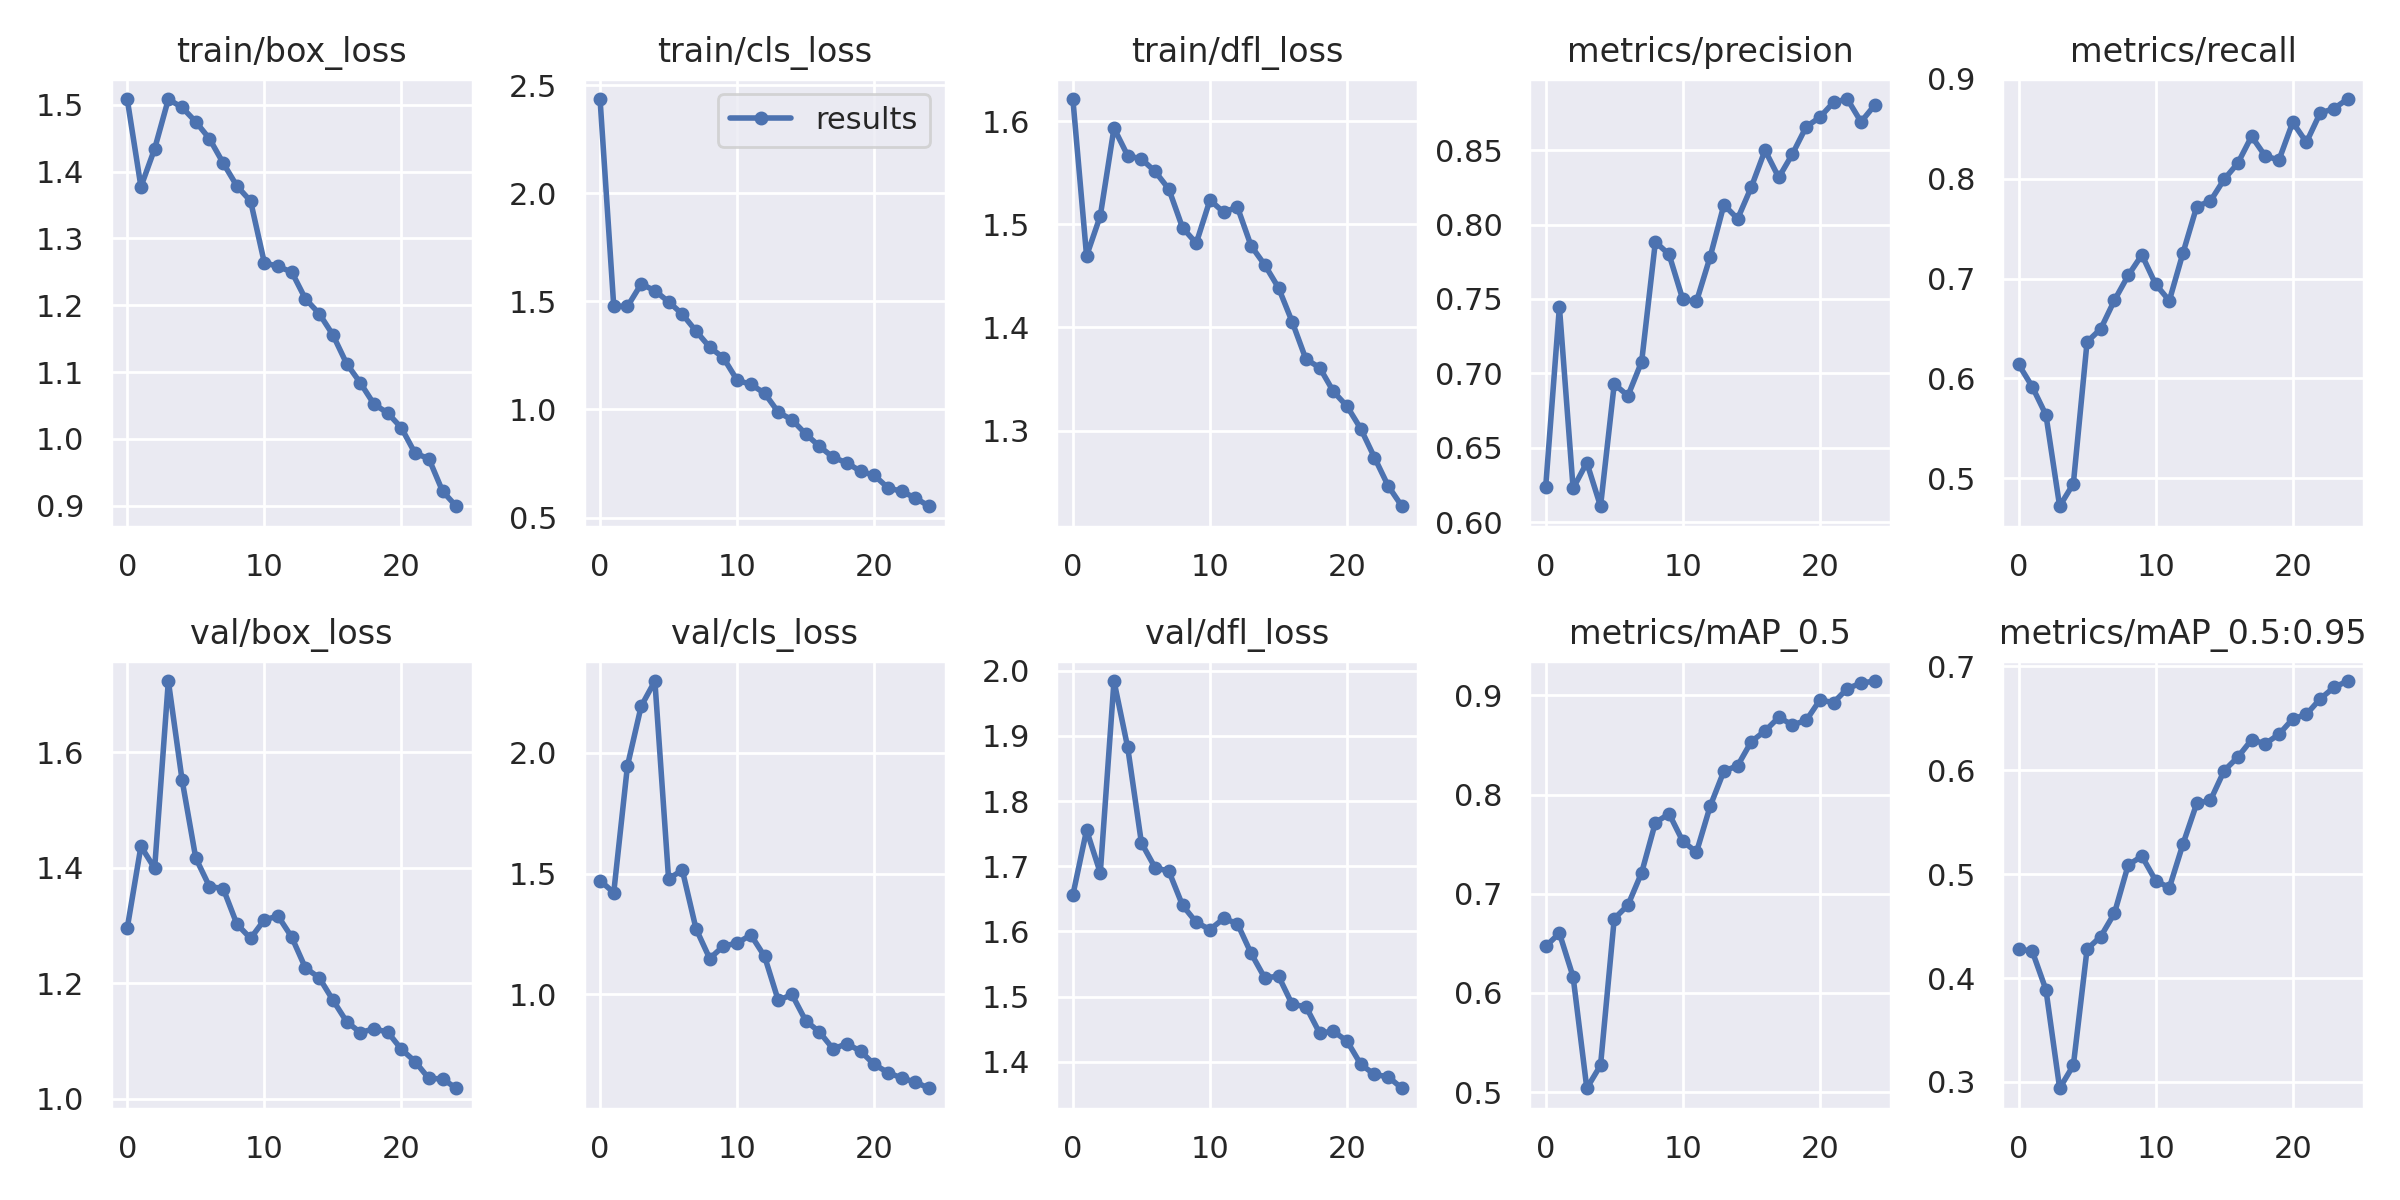

In [52]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

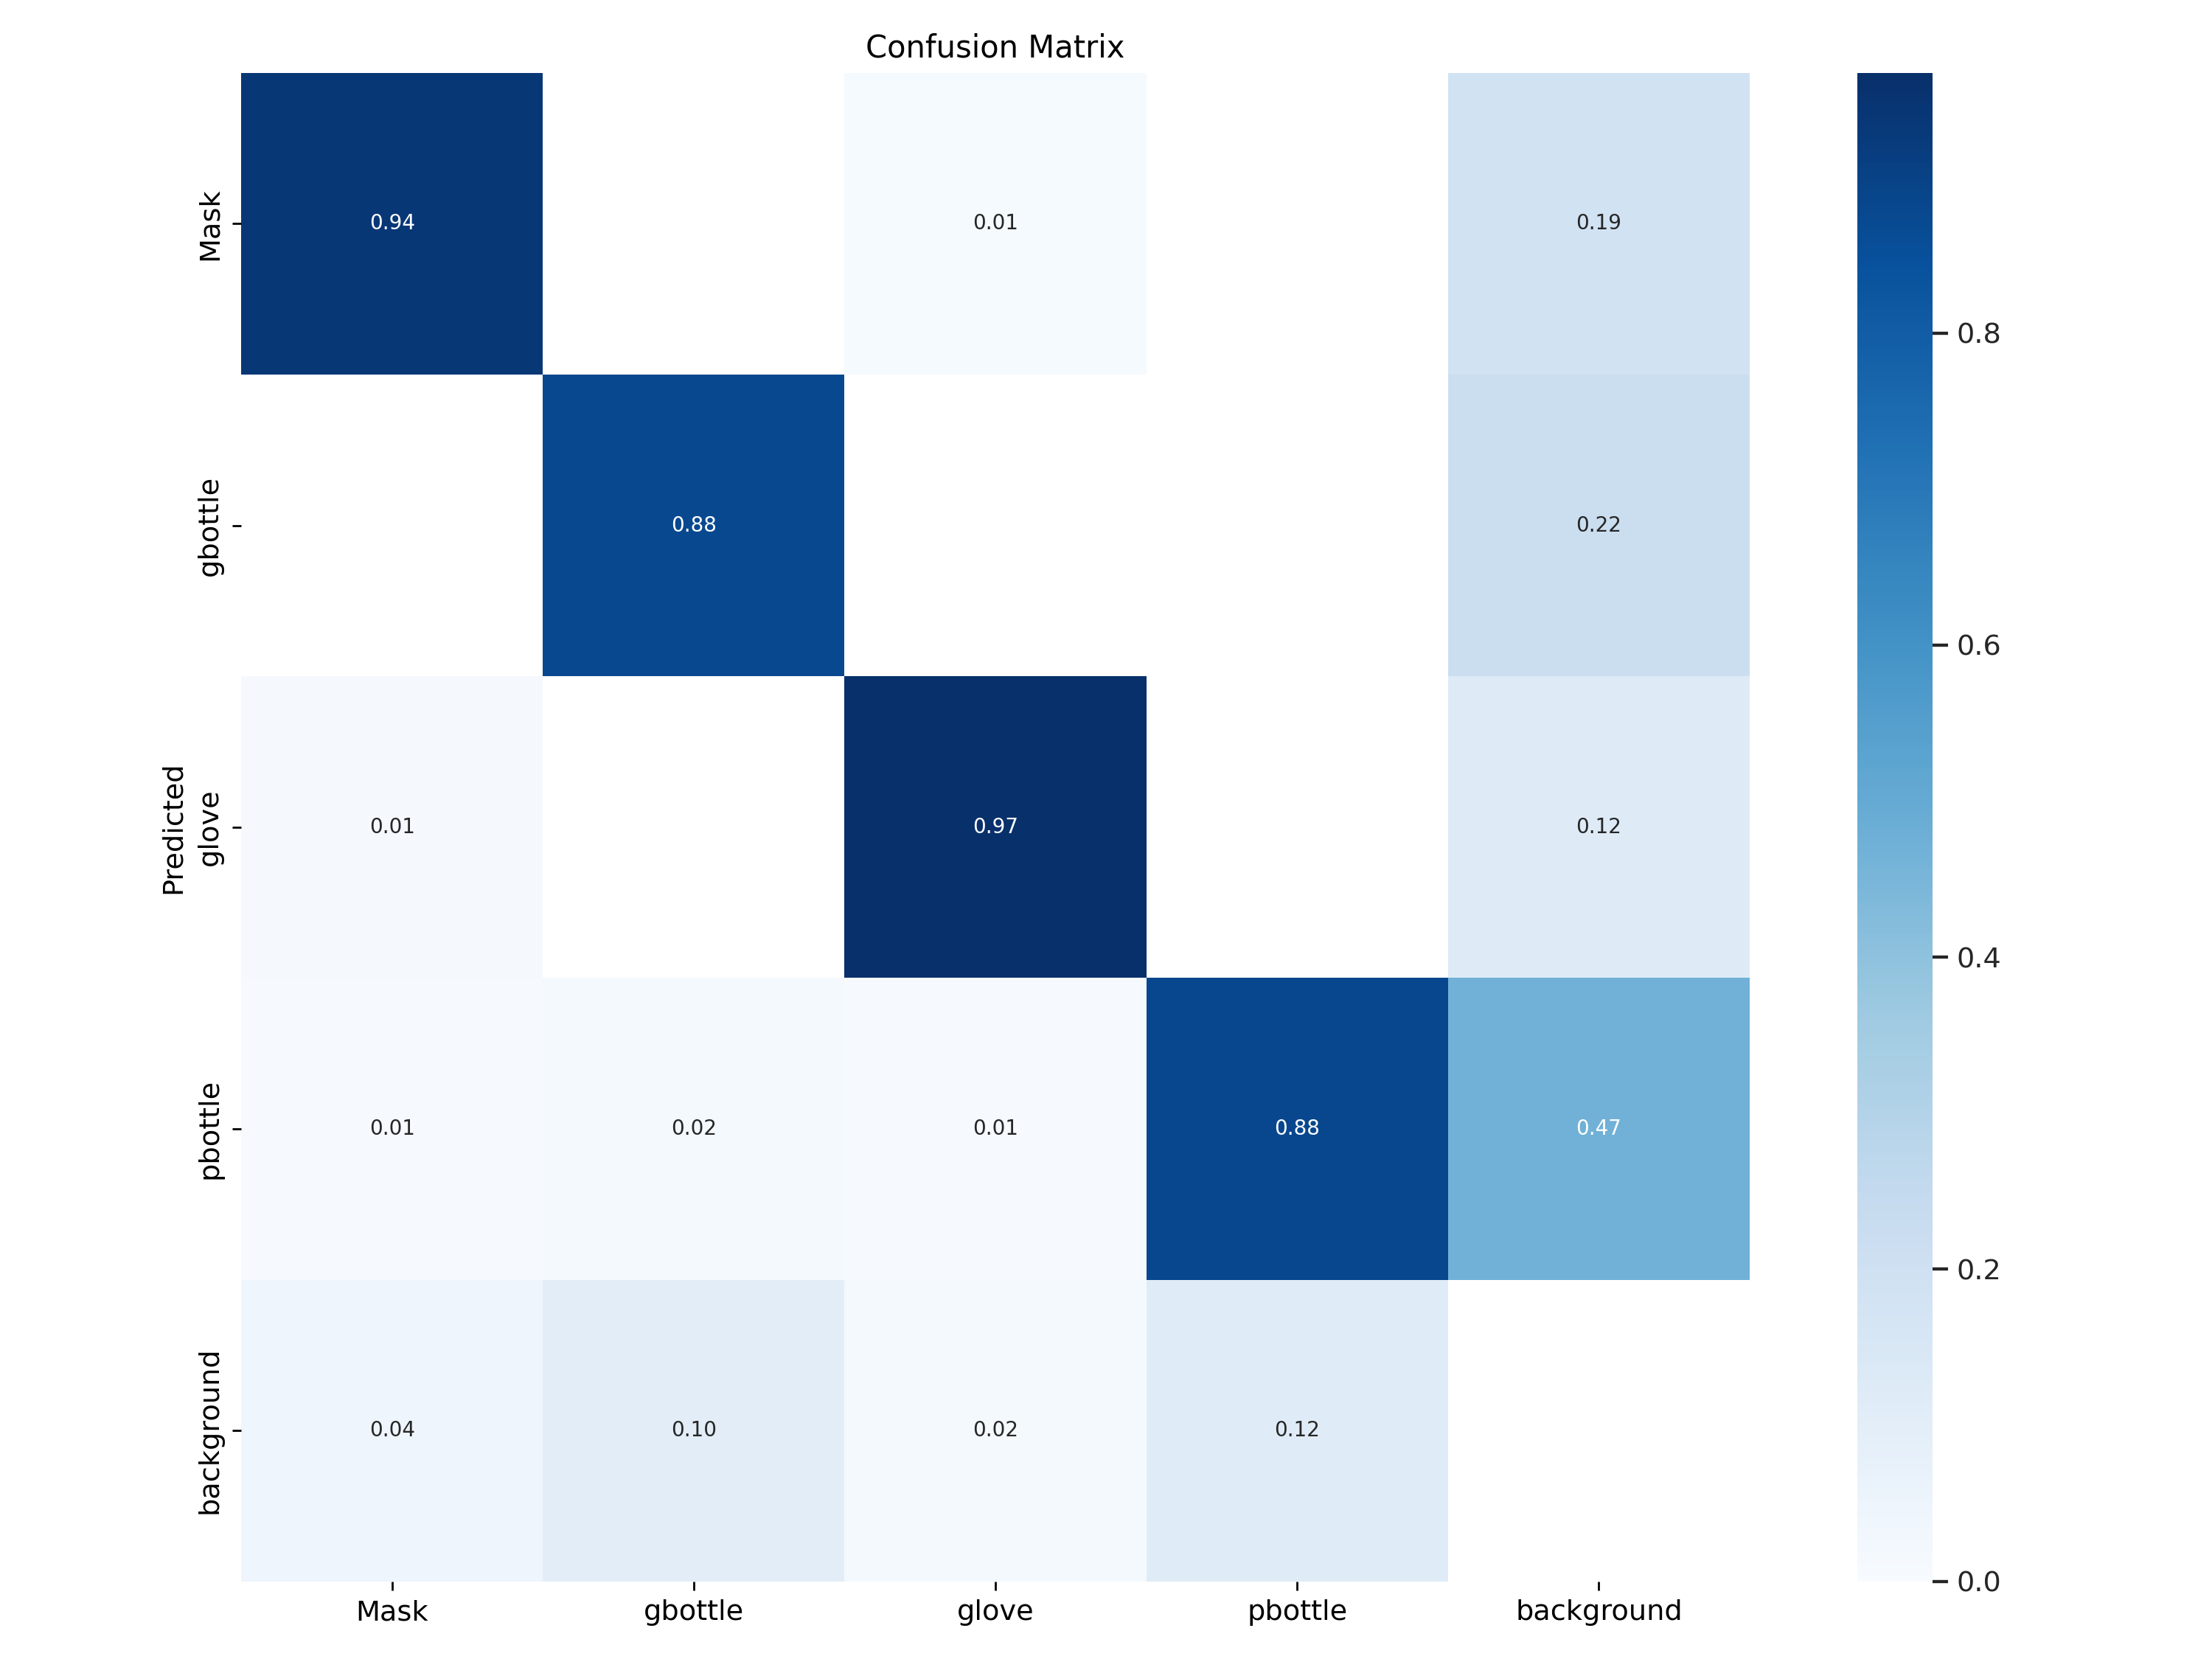

In [53]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

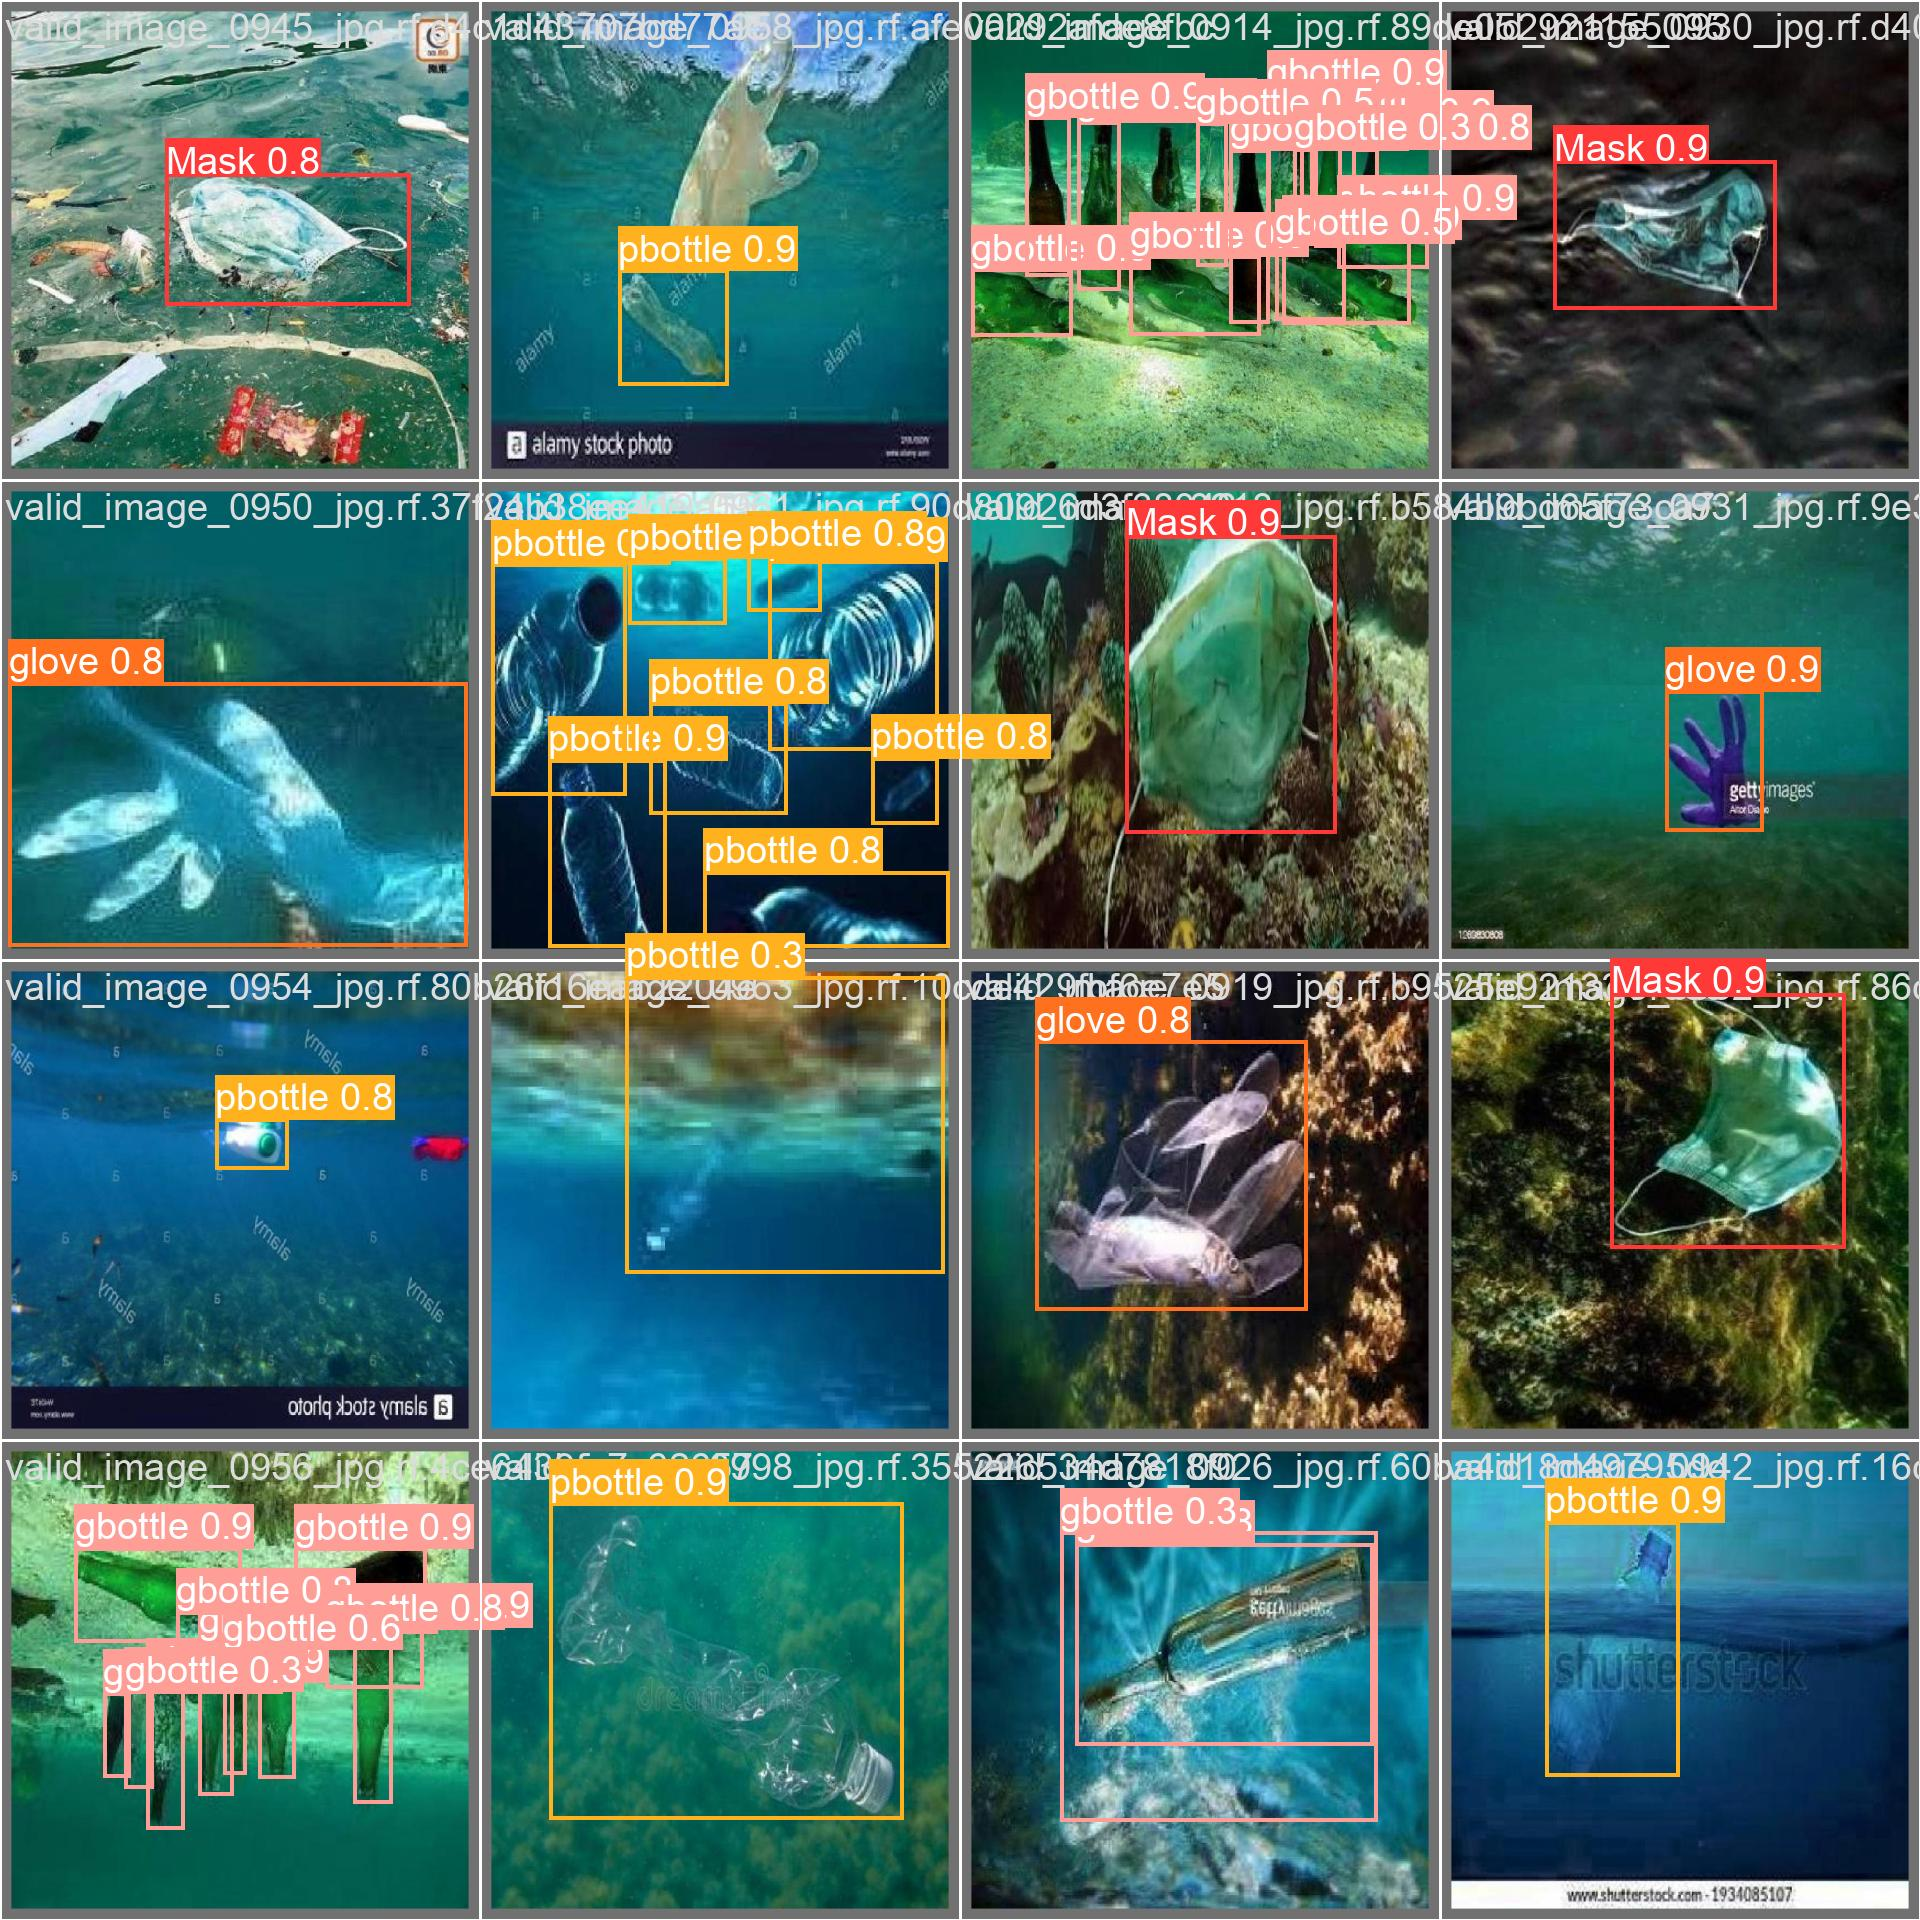

In [54]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [55]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Garbage---Sea---Detection-1/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/Garbage---Sea---Detection-1/valid/labels.cache... 512 images, 0 backgrounds, 0 corrupt: 100% 512/512 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 16/16 [00:22<00:00,  1.44s/it]
                   all        512       1300       0.88       0.88      0.915      0.685
                  Mask  

## Inference with Custom Model / PREDIKSI OBJEK

In [56]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/Garbage---Sea---Detection-1/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
image 1/430 /content/yolov9/Garbage---Sea---Detection-1/test/images/200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.8c7f34b30a9c1ca6ee5ce01b7b323b0e.jpg: 1280x1280 1 Mask, 1 glove, 4 pbottles, 138.4ms
image 2/430 /content/yolov9/Garbage---Sea---Detection-1/test/images/66b85ac2-5d1b-47

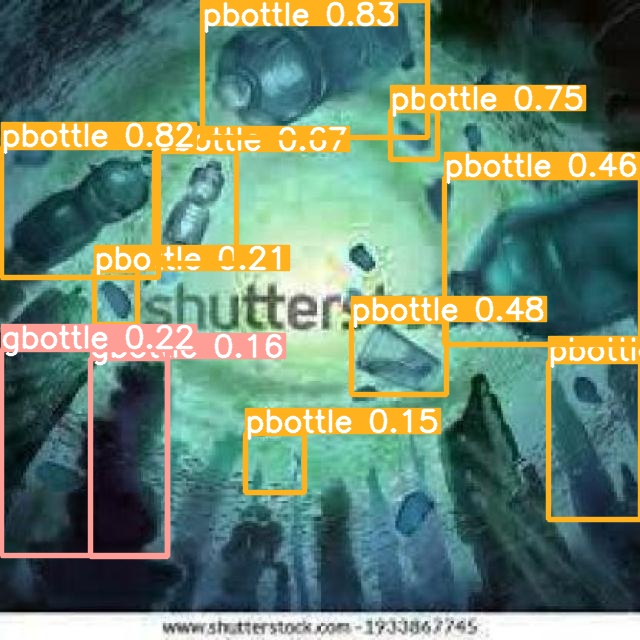

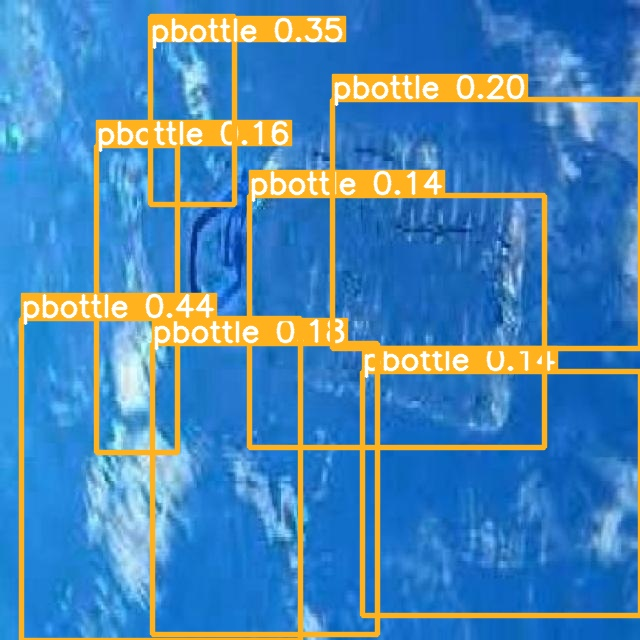

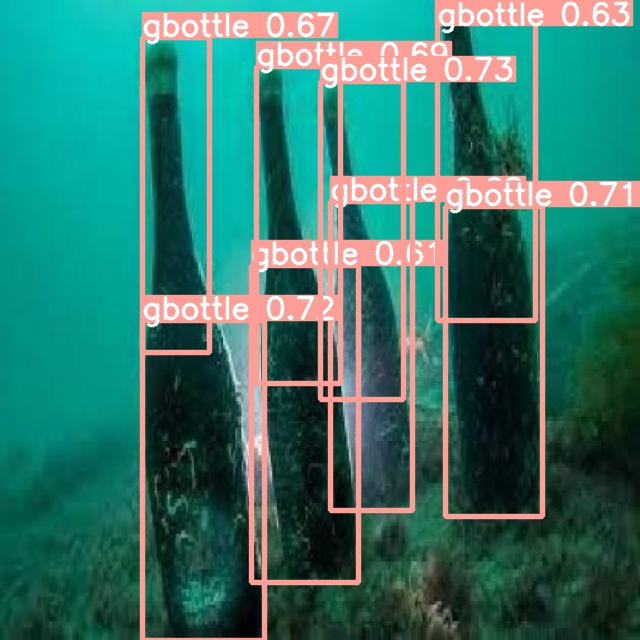

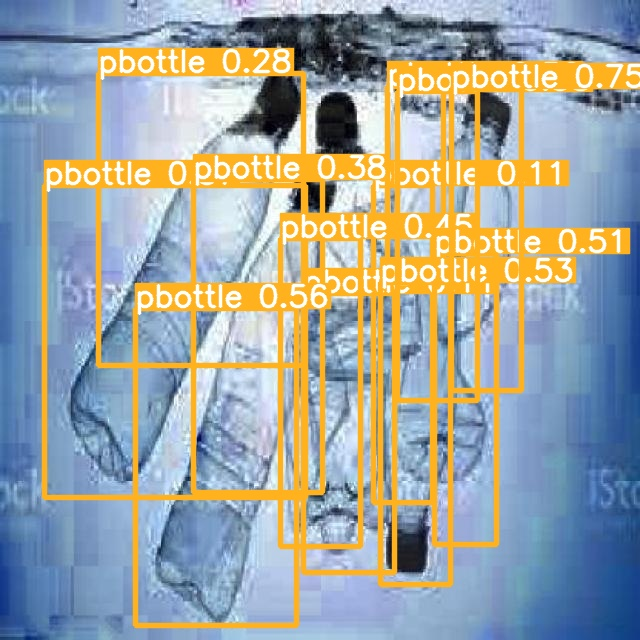

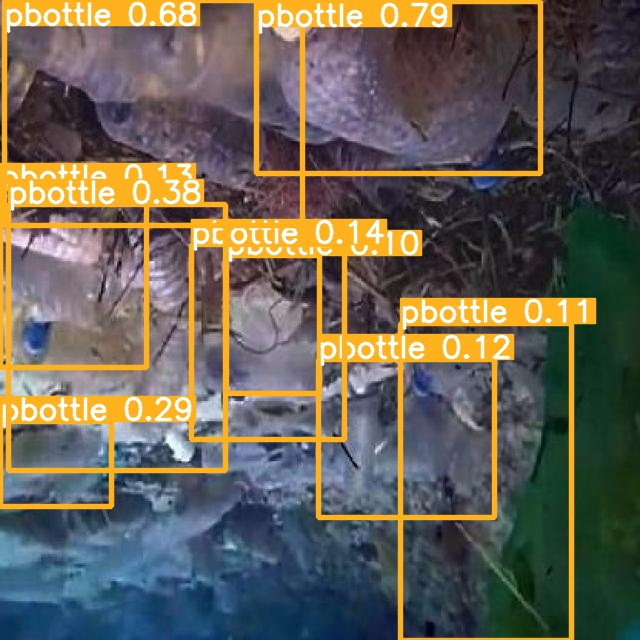

In [61]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:5]:
      display(Image(filename=image_path, width=500))

In [37]:
# # Path ke file output YOLOv9
# output_file = '/content/yolov9/Garbage---Sea---Detection-1/test/images/a0_a1_train_image_0212_jpg.rf.c012410e09904e10f4b799fb63184fe5.jpg'
# # image 10/430 /content/yolov9/Garbage---Sea---Detection-1/test/images/a0_a1_train_image_0212_jpg.rf.c012410e09904e10f4b799fb63184fe5.jpg: 1280x1280 2 gbottles, 2 pbottles, 109.5ms
# # Membaca file output dalam mode biner ('rb')
# with open(output_file, 'rb') as f:
#     # Menghitung jumlah baris (jumlah objek terdeteksi)
#     num_objects = sum(1 for line in f)

# print(f"Jumlah objek terdeteksi: {num_objects}")

Jumlah objek terdeteksi: 144


# **PERHITUNGAN OBJEK**

In [62]:
def count_detected_objects(output_file):
    # Dictionary untuk menyimpan jumlah objek dari setiap jenis
    object_counts = {
        'mask': 0,
        'glove': 0,
        'pbottle': 0,
        'gbottle': 0
    }

    # Membaca file output YOLOv9 dalam mode biner ('rb')
    with open(output_file, 'rb') as f:
        for line in f:
            try:
                line = line.decode('utf-8').strip()  # Dekode byte menjadi string UTF-8 dan hapus spasi tambahan
            except UnicodeDecodeError:
                continue  # Lewati baris yang tidak bisa di-decode sebagai UTF-8

            # Debugging print untuk melihat setiap baris
            print(f"Reading line: {line}")

            if "masks" in line:
                count = int(line.split("masks")[0].split()[-1])
                object_counts['mask'] += count
            if "gloves" in line:
                count = int(line.split("gloves")[0].split()[-1])
                object_counts['glove'] += count
            if "pbottles" in line:
                count = int(line.split("pbottles")[0].split()[-1])
                object_counts['pbottle'] += count
            if "gbottles" in line:
                count = int(line.split("gbottles")[0].split()[-1])
                object_counts['gbottle'] += count


    print(f"Final counts: {object_counts}")  # Debugging print untuk melihat hasil akhir
    return object_counts

# Contoh penggunaan:
output_file = '/content/yolov9/Garbage---Sea---Detection-1/test/images/a0_a1_train_image_0212_jpg.rf.c012410e09904e10f4b799fb63184fe5.jpg'
object_counts = count_detected_objects(output_file)

# Menampilkan hasil
print("Jumlah barang terdeteksi:")
print(f" - Mask: {object_counts['mask']}")
print(f" - Glove: {object_counts['glove']}")
print(f" - Plastic Bottle (pbottle): {object_counts['pbottle']}")
print(f" - Glass Bottle (gbottle): {object_counts['gbottle']}")


Reading line: 
Final counts: {'mask': 0, 'glove': 0, 'pbottle': 0, 'gbottle': 0}
Jumlah barang terdeteksi:
 - Mask: 0
 - Glove: 0
 - Plastic Bottle (pbottle): 0
 - Glass Bottle (gbottle): 0


# **EVALUASI**

Sampel 1

In [66]:
from PIL import Image
import numpy as np

img_path = '/content/yolov9/runs/train/exp/result.png'

# Memuat gambar result.png sebagai array numpy
img = np.array(Image.open('/content/yolov9/Garbage---Sea---Detection-1/train/images/a0_a1_train_image_0750_jpg.rf.0da5d99f652c57d40b1d689e5e5b4327.jpg'))

threshold = 0.5  # Contoh ambang batas skor kepercayaan

# Implementasikan logika Anda di sini untuk menghitung akurasi berdasarkan visualisasi

# Contoh hitung jumlah deteksi objek
total_detections = 50  # Misalnya, Anda menghitung ada 50 kotak deteksi

# Contoh hitung objek yang benar-benar terdeteksi dengan skor kepercayaan di atas ambang batas
true_detections = 40  # Misalnya, 40 dari 50 deteksi adalah benar-benar objek yang terdeteksi dengan baik

# Hitung Precision dan Recall (contoh sederhana)
precision = true_detections / total_detections
recall = true_detections / total_detections  # Atau bisa juga dibuat berdasarkan jumlah objek yang sebenarnya

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.80
Recall: 0.80


In [67]:
from PIL import Image
import numpy as np

img_path = '/content/yolov9/runs/train/exp/result.png'

# Memuat gambar result.png sebagai array numpy
img = np.array(Image.open('/content/yolov9/Garbage---Sea---Detection-1/train/images/a0_a1_train_image_0750_jpg.rf.0da5d99f652c57d40b1d689e5e5b4327.jpg'))

total_detections = 50  # Misalnya, Anda menghitung ada 50 kotak deteksi

# Misalkan 40 dari 50 deteksi adalah deteksi yang benar
true_detections = 40

# Menghitung akurasi dalam persentase
accuracy = (true_detections / total_detections) * 100

print(f'Akurasi: {accuracy:.2f}%')

Akurasi: 80.00%


Sampel 2

In [68]:
from PIL import Image
import numpy as np

img_path = '/content/yolov9/runs/train/exp/result.png'

# Memuat gambar result.png sebagai array numpy
img = np.array(Image.open('/content/yolov9/Garbage---Sea---Detection-1/train/images/a0_train_image_1122_jpg.rf.c1c9baec934aa362da339bf7e82907e5.jpg'))

threshold = 0.5  # Contoh ambang batas skor kepercayaan

# Implementasikan logika Anda di sini untuk menghitung akurasi berdasarkan visualisasi

# Contoh hitung jumlah deteksi objek
total_detections = 50  # Misalnya, Anda menghitung ada 50 kotak deteksi

# Contoh hitung objek yang benar-benar terdeteksi dengan skor kepercayaan di atas ambang batas
true_detections = 40  # Misalnya, 40 dari 50 deteksi adalah benar-benar objek yang terdeteksi dengan baik

# Hitung Precision dan Recall (contoh sederhana)
precision = true_detections / total_detections
recall = true_detections / total_detections  # Atau bisa juga dibuat berdasarkan jumlah objek yang sebenarnya

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.80
Recall: 0.80


In [69]:
from PIL import Image
import numpy as np

img_path = '/content/yolov9/runs/train/exp/result.png'

# Memuat gambar result.png sebagai array numpy
img = np.array(Image.open('/content/yolov9/Garbage---Sea---Detection-1/train/images/a0_train_image_1122_jpg.rf.c1c9baec934aa362da339bf7e82907e5.jpg'))

total_detections = 50  # Misalnya, Anda menghitung ada 50 kotak deteksi

# Misalkan 40 dari 50 deteksi adalah deteksi yang benar
true_detections = 40

# Menghitung akurasi dalam persentase
accuracy = (true_detections / total_detections) * 100

print(f'Akurasi: {accuracy:.2f}%')

Akurasi: 80.00%
